In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from tqdm import tqdm
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [111]:
TRAIN_CSV_PATH = 'dataset/train.csv'
TEST_CSV_PATH = 'dataset/test.csv'
TRAIN_AUDIO_DIR = 'dataset/audios_train/'
TEST_AUDIO_DIR = 'dataset/audios_test/'

In [114]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
train_df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [115]:
train_df.isnull().sum() 

filename    0
label       0
dtype: int64

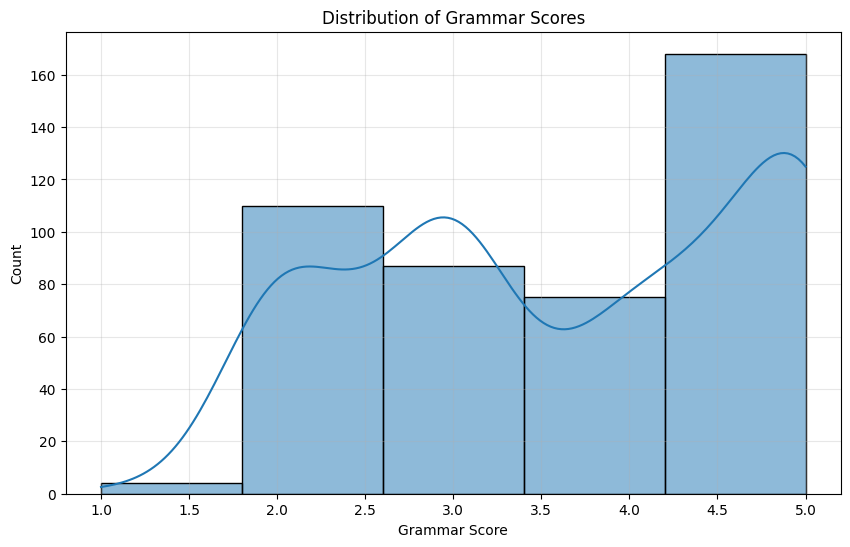

In [116]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['label'], bins=5, kde=True)
plt.title('Distribution of Grammar Scores')
plt.xlabel('Grammar Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

In [117]:
test_df = pd.read_csv(TEST_CSV_PATH)
test_df.head()

,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


In [11]:
def load_audio_sample(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

In [13]:
sample_file = os.path.join(TRAIN_AUDIO_DIR, train_df['filename'].iloc[0])
y, sr = load_audio_sample(sample_file)

In [120]:
print(f"Duration: {len(y)/sr:.2f} seconds")
print(f"Sample rate: {sr} Hz")

Duration: 0.03 seconds
Sample rate: 16000 Hz


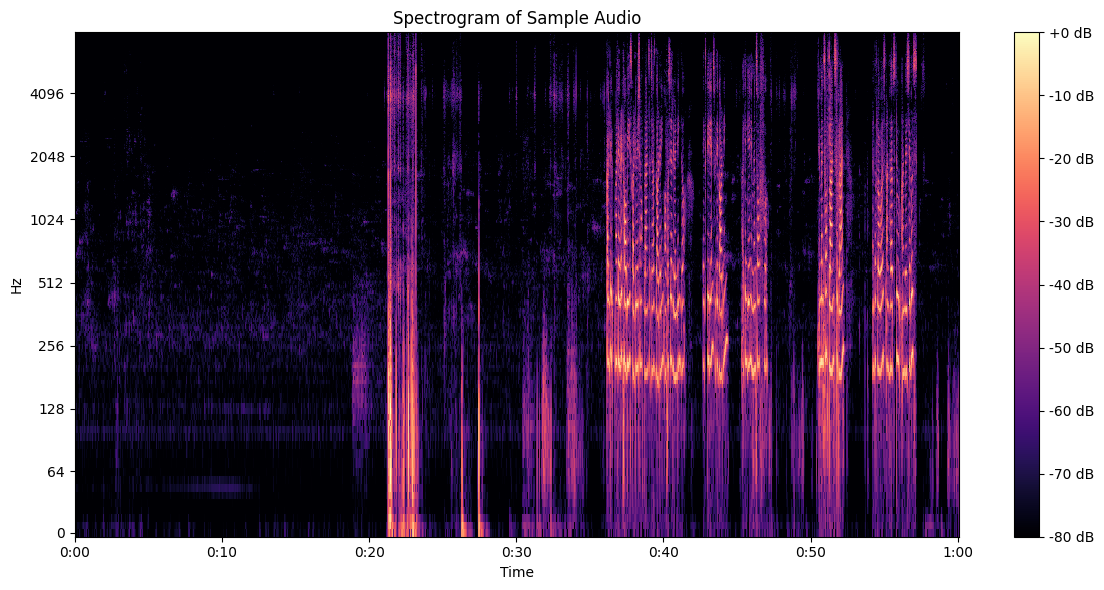

In [17]:
plt.figure(figsize=(12, 6))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Sample Audio')
plt.tight_layout()
plt.show()

#### Feature Extraction

In [122]:
def extract_features(file_path):
    try:

        y, sr = librosa.load(file_path, sr=None)

        duration = len(y)/sr

        zcr = librosa.feature.zero_crossing_rate(y).mean()
        zcr_std = librosa.feature.zero_crossing_rate(y).std()
  
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = mfccs.mean(axis=1)
        mfcc_stds = mfccs.std(axis=1)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = chroma.mean(axis=1)
        chroma_std = chroma.std(axis=1)
        
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_mean = mel_spec.mean(axis=1)
        mel_spec_std = mel_spec.std(axis=1)
 
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
 
        rms = librosa.feature.rms(y=y).mean()
        
        harmonic, percussive = librosa.effects.hpss(y)
        harmonic_mean = np.mean(harmonic)
        harmonic_std = np.std(harmonic)
        percussive_mean = np.mean(percussive)
        percussive_std = np.std(percussive)
        
        features = {
            'duration': duration,
            'zcr_mean': zcr,
            'zcr_std': zcr_std,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_rolloff': spectral_rolloff,
            'tempo': tempo,
            'rms': rms,
            'harmonic_mean': harmonic_mean,
            'harmonic_std': harmonic_std,
            'percussive_mean': percussive_mean,
            'percussive_std': percussive_std
        }
        
        for i, (mean, std) in enumerate(zip(mfcc_means, mfcc_stds)):
            features[f'mfcc{i+1}_mean'] = mean
            features[f'mfcc{i+1}_std'] = std

        for i, (mean, std) in enumerate(zip(chroma_mean, chroma_std)):
            features[f'chroma{i+1}_mean'] = mean
            features[f'chroma{i+1}_std'] = std
            
        for i in range(5): 
            features[f'mel{i+1}_mean'] = mel_spec_mean[i]
            features[f'mel{i+1}_std'] = mel_spec_std[i]
            
        return features
    
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [21]:
train_features = []

for file_name in tqdm(train_df['filename']):
    file_path = os.path.join(TRAIN_AUDIO_DIR, file_name)
    features = extract_features(file_path)
    if features:
        features['filename'] = file_name
        train_features.append(features)


100%|██████████| 444/444 [31:23<00:00,  4.24s/it]


In [124]:
train_features_df = pd.DataFrame(train_features)
train_features_df.head()

,duration,zcr_mean,zcr_std,spectral_centroid,spectral_bandwidth,spectral_rolloff,tempo,rms,harmonic_mean,harmonic_std,...,mel1_std,mel2_mean,mel2_std,mel3_mean,mel3_std,mel4_mean,mel4_std,mel5_mean,mel5_std,filename
0,60.074688,0.143139,0.102392,1812.681453,1710.677609,3517.925486,[110.29411764705883],0.015064,5.063087e-06,0.019872,...,5.065991,0.708353,11.937805,0.993558,14.578185,0.823919,9.561065,1.149033,16.708578,audio_1261.wav
1,60.074688,0.105385,0.115562,1962.232377,1590.935140,3678.718218,[208.33333333333334],0.037655,-2.521378e-06,0.053254,...,0.065379,0.003933,0.052859,0.003314,0.037101,0.004956,0.025717,0.012348,0.051002,audio_942.wav
2,60.074688,0.132682,0.091375,2126.143258,1593.561943,3834.469016,[125.0],0.021168,-6.906313e-07,0.025790,...,0.004323,0.001434,0.004629,0.008132,0.033578,0.408721,1.773403,7.325344,24.141171,audio_1110.wav
3,60.074688,0.094663,0.080789,1296.033816,1256.154774,2438.423522,[125.0],0.041441,9.085867e-07,0.039355,...,0.011951,0.005421,0.029213,0.026966,0.204059,0.811156,2.453352,12.803532,36.198673,audio_1024.wav
4,60.074688,0.136809,0.097716,1601.473150,1444.474832,2949.576511,[133.92857142857142],0.043016,5.457836e-07,0.026966,...,0.009470,0.027062,0.056185,0.019083,0.061254,0.018541,0.047698,0.065317,0.287476,audio_538.wav


In [125]:
train_full = pd.merge(train_features_df, train_df, on='filename')
train_full.head()

,duration,zcr_mean,zcr_std,spectral_centroid,spectral_bandwidth,spectral_rolloff,tempo,rms,harmonic_mean,harmonic_std,...,mel2_mean,mel2_std,mel3_mean,mel3_std,mel4_mean,mel4_std,mel5_mean,mel5_std,filename,label
0,60.074688,0.143139,0.102392,1812.681453,1710.677609,3517.925486,[110.29411764705883],0.015064,5.063087e-06,0.019872,...,0.708353,11.937805,0.993558,14.578185,0.823919,9.561065,1.149033,16.708578,audio_1261.wav,1.0
1,60.074688,0.105385,0.115562,1962.232377,1590.935140,3678.718218,[208.33333333333334],0.037655,-2.521378e-06,0.053254,...,0.003933,0.052859,0.003314,0.037101,0.004956,0.025717,0.012348,0.051002,audio_942.wav,1.5
2,60.074688,0.132682,0.091375,2126.143258,1593.561943,3834.469016,[125.0],0.021168,-6.906313e-07,0.025790,...,0.001434,0.004629,0.008132,0.033578,0.408721,1.773403,7.325344,24.141171,audio_1110.wav,1.5
3,60.074688,0.094663,0.080789,1296.033816,1256.154774,2438.423522,[125.0],0.041441,9.085867e-07,0.039355,...,0.005421,0.029213,0.026966,0.204059,0.811156,2.453352,12.803532,36.198673,audio_1024.wav,1.5
4,60.074688,0.136809,0.097716,1601.473150,1444.474832,2949.576511,[133.92857142857142],0.043016,5.457836e-07,0.026966,...,0.027062,0.056185,0.019083,0.061254,0.018541,0.047698,0.065317,0.287476,audio_538.wav,2.0


In [126]:
train_full.isnull().sum().sum()

0

##### calculating the top features most correlated with label to understand feature relevance


In [127]:
features_only = train_full.drop(['filename', 'label'], axis=1)
correlations = []

In [128]:
for col in features_only.columns:
    corr = pearsonr(pd.to_numeric(train_full[col], errors='coerce'), train_full['label'])[0]
    correlations.append((col, corr))

In [129]:
correlations.sort(key=lambda x: abs(x[1]), reverse=True)

In [130]:
top_n = 20
top_features = [x[0] for x in correlations[:top_n]]
top_corrs = [x[1] for x in correlations[:top_n]]

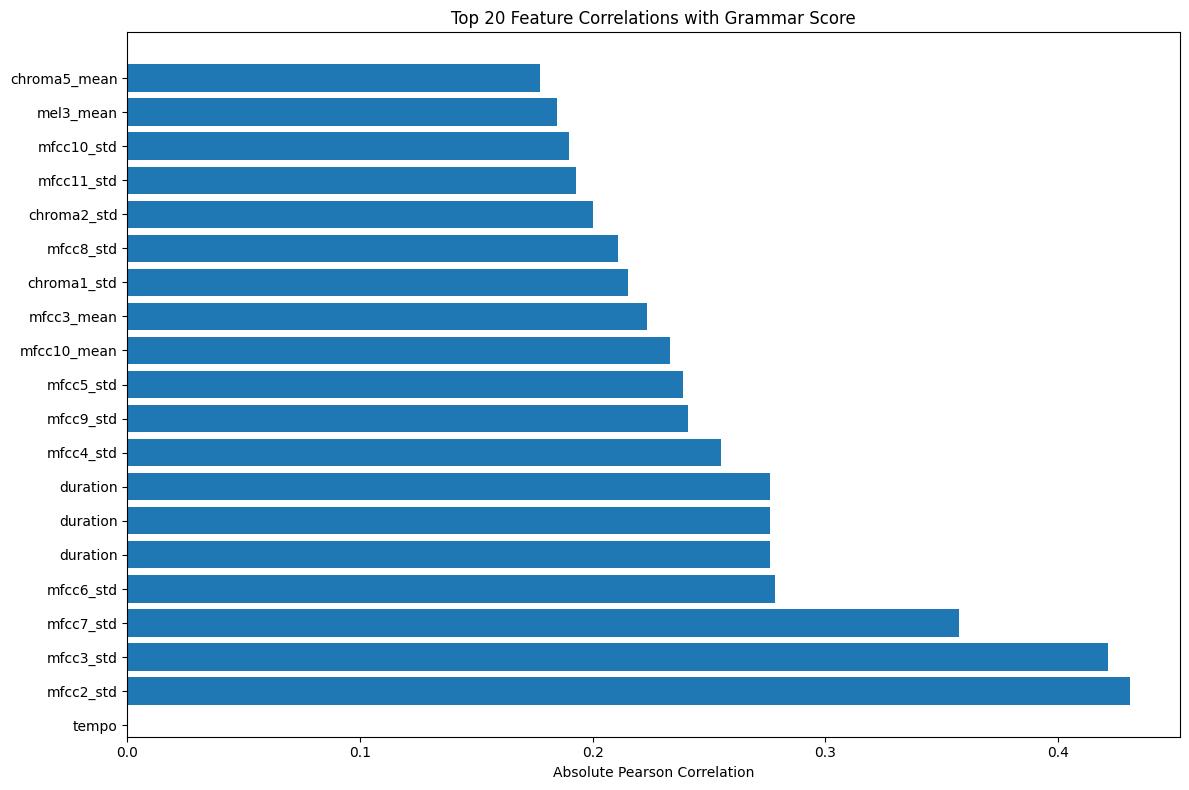

In [46]:
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), [abs(c) for c in top_corrs], align='center')
plt.yticks(range(top_n), top_features)
plt.title(f'Top {top_n} Feature Correlations with Grammar Score')
plt.xlabel('Absolute Pearson Correlation')
plt.tight_layout()
plt.show()

##### training the model 

In [139]:
X = train_full.drop(['filename', 'label'], axis=1)
y = train_full['label']
feature_names = X.columns.tolist()

In [140]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [142]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

##### Linear Regression

In [143]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_val_scaled)
lr_pearson = pearsonr(y_val, lr_preds)[0]
lr_rmse = np.sqrt(mean_squared_error(y_val, lr_preds))

In [144]:
lr_pearson, lr_rmse

(0.502066920191227, 1.0603774196785056)

##### Ridge Regression

In [145]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_preds = ridge_model.predict(X_val_scaled)
ridge_pearson = pearsonr(y_val, ridge_preds)[0]
ridge_rmse = np.sqrt(mean_squared_error(y_val, ridge_preds))

In [146]:
ridge_pearson, ridge_rmse

(0.5153686809267627, 1.0437573439157357)

##### Random Forest

In [147]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_pearson = pearsonr(y_val, rf_preds)[0]
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_preds))

In [148]:
rf_pearson, rf_rmse

(0.6291462215729599, 0.9300972523754731)

##### Gradient Boosting

In [149]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_val)
gb_pearson = pearsonr(y_val, gb_preds)[0]
gb_rmse = np.sqrt(mean_squared_error(y_val, gb_preds))

In [150]:
gb_pearson, gb_rmse

(0.6367268669130323, 0.9031112909854035)

##### XGBoost

In [151]:
X_train_xgb = X_train.apply(pd.to_numeric, errors='coerce')
X_val_xgb = X_val.apply(pd.to_numeric, errors='coerce')

In [152]:
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_xgb, y_train)
xgb_preds = xgb_model.predict(X_val_xgb)
xgb_pearson = pearsonr(y_val, xgb_preds)[0]
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_preds))

In [154]:
xgb_pearson, xgb_rmse

(0.5639699630417538, 0.9658915161117155)

##### Trying to train a simple newural network

In [155]:
class AudioNN(nn.Module):
    def __init__(self, input_size):
        super(AudioNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [156]:
class AudioDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        if y is not None:
            self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        else:
            self.y = None
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]


In [157]:
def train_nn(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):

        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                val_loss = criterion(outputs, y_batch)
                running_val_loss += val_loss.item()
        
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

In [158]:
train_dataset = AudioDataset(X_train_scaled, y_train)
val_dataset = AudioDataset(X_val_scaled, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [159]:
input_size = X_train_scaled.shape[1]
nn_model = AudioNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

In [160]:
train_losses, val_losses = train_nn(nn_model, train_loader, val_loader, criterion, optimizer, epochs=50)


Epoch 10/50, Train Loss: 1.1637, Val Loss: 1.1575
Epoch 20/50, Train Loss: 0.8475, Val Loss: 0.9820
Epoch 30/50, Train Loss: 0.7162, Val Loss: 1.0149
Epoch 40/50, Train Loss: 0.5366, Val Loss: 1.0321
Epoch 50/50, Train Loss: 0.4967, Val Loss: 1.1145


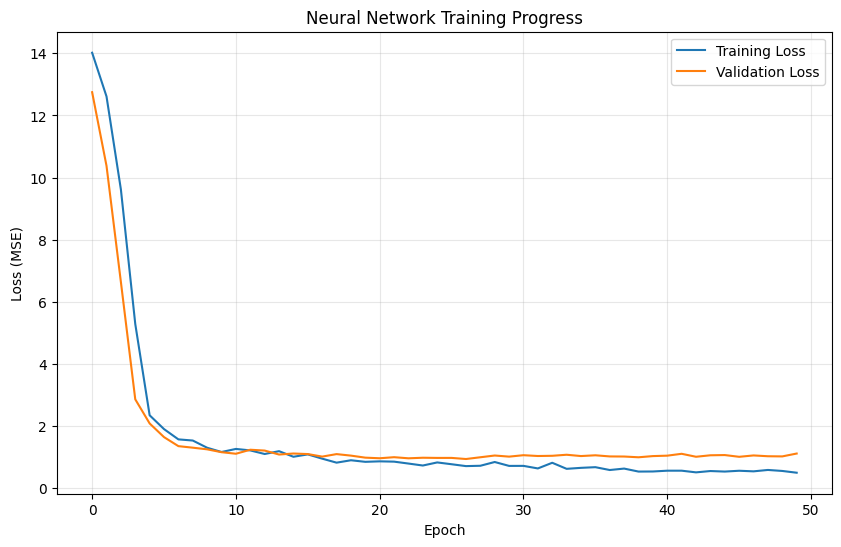

In [161]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Neural Network Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [162]:
nn_model.eval()
with torch.no_grad():
    val_preds = nn_model(torch.tensor(X_val_scaled, dtype=torch.float32)).numpy().flatten()

nn_pearson = pearsonr(y_val, val_preds)[0]
nn_rmse = np.sqrt(mean_squared_error(y_val, val_preds))


In [163]:
nn_pearson, nn_rmse

(0.5514821237336399, 1.0440677904527036)

In [175]:
pearson_scores = [lr_pearson, ridge_pearson, rf_pearson, gb_pearson, xgb_pearson, nn_pearson]
rmse_scores = [lr_rmse, ridge_rmse, rf_rmse, gb_rmse, xgb_rmse, nn_rmse]

pearson_scores, rmse_scores

([0.502066920191227,
  0.5153686809267627,
  0.6291462215729599,
  0.6367268669130323,
  0.5639699630417538,
  0.5514821237336399],
 [1.0603774196785056,
  1.0437573439157357,
  0.9300972523754731,
  0.9031112909854035,
  0.9658915161117155,
  1.0440677904527036])

###### Most likely gradient boosing reg. is performing best

##### Test data

In [92]:
test_features = []

for file_name in tqdm(test_df['filename']):
    file_path = os.path.join(TEST_AUDIO_DIR, file_name)
    features = extract_features(file_path)
    if features:
        features['file_name'] = file_name
        test_features.append(features)

100%|██████████| 195/195 [15:11<00:00,  4.68s/it]


In [164]:
test_features_df = pd.DataFrame(test_features)
test_features_df.head()

,duration,zcr_mean,zcr_std,spectral_centroid,spectral_bandwidth,spectral_rolloff,tempo,rms,harmonic_mean,harmonic_std,...,mel1_std,mel2_mean,mel2_std,mel3_mean,mel3_std,mel4_mean,mel4_std,mel5_mean,mel5_std,file_name
0,60.074688,0.150859,0.070008,1652.834782,1421.570396,3048.963325,[144.23076923076923],0.031372,-1.372201e-07,0.030744,...,0.034614,0.076899,0.923238,0.599142,9.891989,0.670169,9.132087,0.592407,3.522379,audio_706.wav
1,60.074688,0.150618,0.063260,1611.261856,1390.201883,2924.828608,[117.1875],0.033988,-2.648800e-07,0.020942,...,0.063854,0.439681,4.903012,6.556119,88.993332,4.016085,54.126820,1.992239,13.215044,audio_800.wav
2,61.034687,0.136084,0.120232,1305.127791,1237.451798,2389.933012,[117.1875],0.054290,1.630335e-06,0.038339,...,0.005026,0.005683,0.007652,0.014979,0.048050,0.960503,2.308738,4.221021,6.916209,audio_68.wav
3,54.080000,0.210088,0.152892,2162.147753,1637.414280,3880.373115,[117.1875],0.050933,6.022136e-07,0.046033,...,0.007847,0.005208,0.019358,0.005311,0.028936,0.004368,0.016915,0.008179,0.035466,audio_1267.wav
4,60.074688,0.077122,0.039145,1271.088190,1496.800164,2762.783713,[117.1875],0.040125,3.524267e-06,0.042427,...,0.074821,0.050453,0.066940,0.016925,0.037886,0.269773,0.389710,6.564624,11.304221,audio_683.wav


##### Final Model Training on complete train data & predicting on test data & saving the predictions 

In [ ]:
def save_preds(test_preds, file_path):

    preds = np.clip(test_preds, 1, 5) #clipping scores to be between 1 and 5
    
    pred_df = pd.DataFrame({
    'filename': test_features_df['file_name'],
    'label': preds
    })
    pred_df.to_csv(file_path, index=False)

###### Linear Regression

In [176]:
lr = LinearRegression()
X_scaled = scaler.fit_transform(X)
lr.fit(X_scaled, y)

X_test = test_features_df.drop(['file_name'], axis=1)
X_test_scaled = scaler.transform(X_test)

lr_preds = lr.predict(X_test_scaled)

In [180]:
save_preds(lr_preds, 'lr_preds.csv')

###### Ridge Regression

In [181]:
ridge = Ridge(alpha=1.0)
X_scaled = scaler.fit_transform(X)
ridge.fit(X_scaled, y)

X_test = test_features_df.drop(['file_name'], axis=1)
X_test_scaled = scaler.transform(X_test)

ridge_preds = ridge.predict(X_test_scaled)

In [182]:
save_preds(ridge_preds, 'ridge_preds.csv')

###### Random Forest

In [183]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

X_test = test_features_df.drop(['file_name'], axis=1)
rf_preds = rf.predict(X_test)

In [184]:
save_preds(rf_preds, 'rf_preds.csv')

###### Gradient Boosting Regression

In [185]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X, y)

X_test = test_features_df.drop(['file_name'], axis=1)
gb_preds = gb.predict(X_test)

In [186]:
save_preds(gb_preds, 'gb_preds.csv')

###### XGBoost

In [191]:
X_train_xgb = X.apply(pd.to_numeric, errors='coerce')
X_test_xgb = X_test.apply(pd.to_numeric, errors='coerce')

In [196]:
xgb_model.fit(X_train_xgb, y)

X_test = test_features_df.drop(['file_name'], axis=1)
xgb_preds = xgb_model.predict(X_test_xgb)

In [197]:
save_preds(xgb_preds, 'xgb_preds.csv')

###### neural network (not performing good, was just trying)

In [200]:
full_dataset = AudioDataset(scaler.fit_transform(X), y)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

nn = AudioNN(input_size)
optimizer = optim.Adam(nn.parameters(), lr=0.001)

train_nn(nn, full_loader, full_loader, criterion, optimizer, epochs=50)

Epoch 10/50, Train Loss: 0.9819, Val Loss: 0.7081
Epoch 20/50, Train Loss: 0.7197, Val Loss: 0.4682
Epoch 30/50, Train Loss: 0.6446, Val Loss: 0.3797
Epoch 40/50, Train Loss: 0.5551, Val Loss: 0.2978
Epoch 50/50, Train Loss: 0.4606, Val Loss: 0.2725


([11.749005658285958,
  9.417554446629115,
  5.252495288848877,
  2.4321355308805193,
  1.8180169378008162,
  1.4995612331799097,
  1.309962945325034,
  1.291882961988449,
  1.0438079365662165,
  0.9819325421537671,
  0.8879089398043496,
  0.9913746288844517,
  0.969577989407948,
  0.9269701285021645,
  0.9049482835190636,
  0.8431879239422935,
  0.8002936158861432,
  0.7872730706419263,
  0.7795897232634681,
  0.7196648823363441,
  0.7001407955374036,
  0.7444631031581334,
  0.6809517038719994,
  0.7209135740995407,
  0.6932502601827893,
  0.6527170879500253,
  0.7286451033183506,
  0.6390994191169739,
  0.6586863079241344,
  0.6446246547358376,
  0.6023340693541935,
  0.6383012703486851,
  0.6301497880901609,
  0.6118157122816358,
  0.5442561336926052,
  0.5368328626666751,
  0.5536637731960842,
  0.5823050418070385,
  0.5113419996840614,
  0.5550701894930431,
  0.5698264539241791,
  0.5386137217283249,
  0.5121013926608222,
  0.5284590529544013,
  0.442856741803033,
  0.546425131814

In [205]:
X_test = test_features_df.drop(['file_name'], axis=1)
X_test_scaled = scaler.transform(X_test)

nn.eval()
with torch.no_grad():
    nn_preds = nn(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy().flatten()

In [207]:
save_preds(nn_preds, "nn_preds.csv")